<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Analysis of the 2004 Sumatra-Andaman earthquake</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Part 1: Instrument response and spectral analysis</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Andita Aiman
* Tomy Gunawan
* Angel Ling


Based on *GEOS 626: Applied Seismology from Carl Tape*

The goals of this problem set are:
1. to practice deconvolving the instrument response from a raw seismogram recorded in “counts”
2. to introduce you to the frequency dependence of the seismic wavefield, especially with regard to seismological investigations of earthquake sources and Earth structure

## Problem 3: Spectral Analysis of Noise

In [3]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from IPython.display import display, Math, Latex
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pylab as plt
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper 
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach
plt.style.use('ggplot')

### Exercise 1

Using the GCMT catalog, list the magnitude, location, and origin time of the conspicuous event!

1 Event(s) in Catalog:
2004-12-23T14:59:00.680000Z | -49.710, +161.576 | 8.1 MW


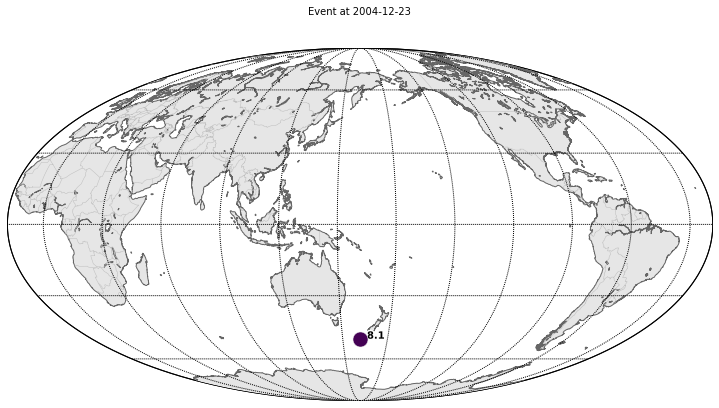

In [5]:
# IRIS is the biggest seismological data center, based in the US
client_iris = Client("IRIS")

catalog = client_iris.get_events(minmagnitude=8.0, starttime="2004-12-16", endtime="2004-12-26")

print(catalog)
catalog.plot();

It turns out that three days before the Sumatra earthquake there was a Mw 8.1 earthquake south of New Zealand on the boundary between the Australia and Pacific plates. For further information about the moment tensor of the earthquake please see GCMT catalog.

(http://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT4/form?itype=ymd&yr=2004&mo=12&day=23&oyr=1976&omo=1&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=1&lmw=8&umw=10&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=0)

### Excersise 2
Extract a multi-day time series that does not contain any earthquake-like signals from CAN station. What is the dominant period?

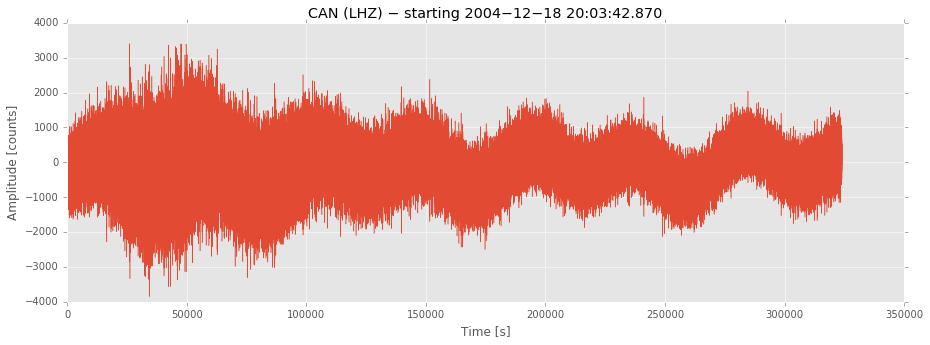

In [26]:
# Remove obvious earthquake 
t = UTCDateTime("2004-12-18T20:03:42.870")
starttime = t         # 90 hours before the New Zealand earthquake
endtime = t+(90*3600) # the original time of the New Zealand earthquake

st = client.get_waveforms("G", "CAN", "*", "LHZ", starttime, endtime, attach_response=True)

# Plotting signals
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5
tr = st[0]
plt.plot(tr.data)
plt.title('CAN (LHZ) − starting 2004−12−18 20:03:42.870')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [counts]')

Figure above shows a 90-hour time series of noise that does not contain any obvious earthquakes. The 12-hour tidal period is the dominant period.

### Exercise 3

1. Now use your earthquake-free time series. Following the procedure in Problem 2, deconvolve the instrument response. Plot the amplitude spectrum of acceleration using log-log scaling and the frequency limits ${10^−}^4$ Hz to $10^1$ Hz.
2. On your plot, mark the ocean microseismic period ranges 5–8 s and 10–16 s that are mentioned in Shearer (2009, Section 11.2).
3. Qualitatively, how does your spectrum compare with Figure 11.6 of Shearer (2009)?
4. Based on this observation, and considering all possible periods, what period range at CAN will provide the highest signal-to-noise ratio?

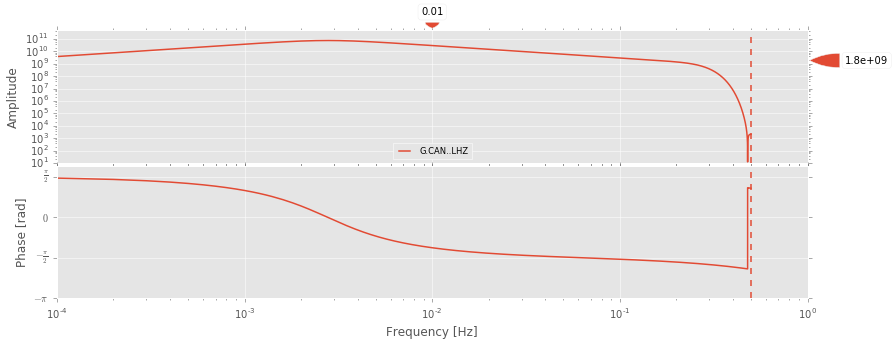

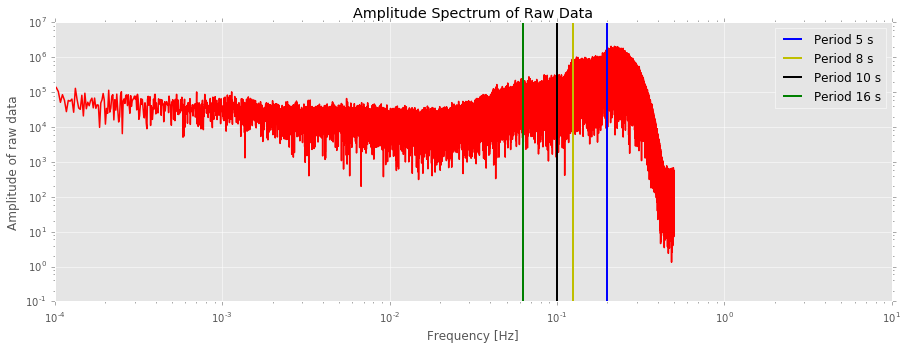

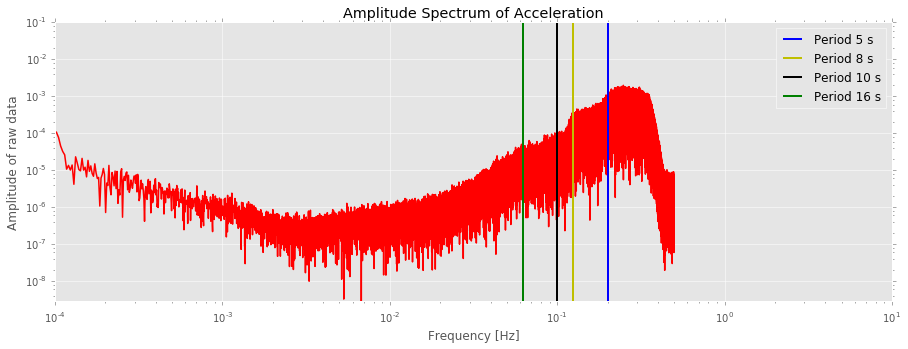

In [24]:
# Instrument response
inv = client.get_stations(network="G", station="CAN", channel="LHZ", level="response", starttime=starttime, endtime=endtime)

inv.plot_response(min_freq=1E-4, output='ACC')

#Fourier transform of raw data
tr_raw = st.copy()
y  = tr_raw[0].data                         
taper_percentage = 0.1                          # Percentage of tapering applied to signal
taper = cosine_taper(npts,taper_percentage)     # Define cosine taper to be used
y_taper = y * taper                             # Taper signal
y_detrend = detrend(y_taper, 'linear')          # Detrend Signal
y_fraw = np.fft.rfft(y_detrend) 

#Fourier transform of acceleraation data
tr = st.select(component="Z").copy().remove_response(inventory=inv, output="ACC")[0].taper(0.05)
D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

# Set up frequency windows
k = [1/5, 1/8, 1/10, 1/16]
color = ['b','y','k','g']
label = ['Period 5 s','Period 8 s','Period 10 s','Period 16 s']


#plotting parameter
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['lines.linewidth'] = 0.5

# Plot in Spectrum of Raw data
plt.loglog(freqs, abs(y_fraw), 'r', lw=1.5) 
for i in range(len(k)):
    c = plt.axvline(k[i], color=color[i], label=label[i], lw=2)
plt.title('Amplitude Spectrum of Raw Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude of raw data')
plt.legend()
plt.xlim(1.0E-4, 10.0)
plt.ylim(1E-1, 1E7) # limited to lower frquencies
plt.show()

# Plot in Spectrum of Acceleration
plt.loglog(freqs, abs(D), 'r', lw=1.5) 
for i in range(len(k)):
    c = plt.axvline(k[i], color=color[i], label=label[i], lw=2)
plt.title('Amplitude Spectrum of Acceleration')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude of raw data')
plt.legend()
plt.xlim(1.0E-4, 10.0)
plt.ylim(0, 1E-1) # limited to lower frquencies
plt.show()


1. Figures above compares the amplitude spectrum of noise for the raw time series and for the instrument-deconvolved acceleration.
2. The period ranges 5–8 s and 10–16 s mentioned in <b><i>Shearer (2009, Section 11.2)</i></b> are not exactly aligned with noise spectrum at Canberra. This is not surprising since this is one station at one particular time, whereas the Shearer figure is a global average, presumably over yearly time intervals. The spectral peaks associated with ocean microseisms will depend on the location of the storm that is generating the waves with periods 10–16 s.
3. Based on the CAN noise spectrum, we expect the best signal-to-noise ratio at frequencies near the Nyquist and also over the period range 50–500 s


<img src="images/shearer 11_2.png" style="width: 500px; float: left;"/>

**Shearer (2009, Section 11.2)**

### References

* Ammon, C. J., et al. (2005), Rupture process of the 2004 Sumatra-Andaman earthquake, *Science, 308*, 1133–1139.
* Dahlen, F. A., and J. Tromp (1998), *Theoretical Global Seismology*, Princeton U. Press, Princeton, New Jersey, USA.
* Lay, T., et al. (2005), The great Sumatra-Andaman earthquake of 26 December 2004, *Science, 308*, 1127–1133.
* Ni, S., D. Helmberger, and H. Kanamori (2005), Energy radiation from the Sumatra earthquake, *Nature*, 434, 582.
* Park, J., et al. (2005), Earth’s free oscillations excited by the 26 December 2004 Sumatra Andaman earthquake, *Science, 308*, 1139–1144.
* Shearer, P. M. (2009), *Introduction to Seismology*, 2 ed., Cambridge U. Press, Cambridge, UK.
* Stein, S., and M. Wysession (2003), *An Introduction to Seismology, Earthquakes, and Earth Structure*, Blackwell, Malden, Mass., USA.